<a href="https://colab.research.google.com/github/shrabonbiswas/Thesis/blob/main/Copy_of_MDD_with_DA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import library

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.io import imread


In [ ]:
import os
import shutil

# Source: Google Drive file
src_file = "/content/drive/MyDrive/Thesis/dataset/thesis.zip"

# Destination: Colab local directory
dest_file = "/content/thesis.zip"

# ফাইল আছে কিনা চেক করা
if os.path.exists(src_file):
    shutil.copy(src_file, dest_file)
    print("✅ File copied successfully!")
else:
    print(f"❌ Source file পাওয়া যায়নি: {src_file}")

✅ File copied successfully!


In [ ]:
import zipfile
import os

zip_path = '/content/thesis.zip'
extract_path = '/content/extracted_thesis'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"✅ File extracted to: {extract_path}")

✅ File extracted to: /content/extracted_thesis


In [ ]:
import os

dest_path = "/content/extracted_thesis/data"
dataset_path = dest_path

total_images = 0
class_counts = {}

for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        num_images = len([
            f for f in os.listdir(class_dir)
            if os.path.isfile(os.path.join(class_dir, f))
        ])
        class_counts[class_name] = num_images
        total_images += num_images

print(f"\n✅ Total number of images: {total_images}")
print(f"✅ Number of classes: {len(class_counts)}")
print("📊 Images per class:")
for cls, count in class_counts.items():
    print(f"  {cls}: {count} images")



✅ Total number of images: 4188
✅ Number of classes: 4
📊 Images per class:
  Gray_Leaf_Spot: 574 images
  Common_Rust: 1306 images
  Healthy: 1162 images
  Blight: 1146 images


📌 Selected Image: Corn_Blight (197).JPG


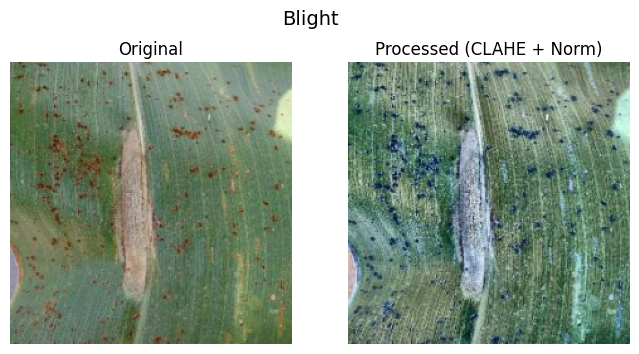

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import random   # নতুন যোগ করা হয়েছে

# ✅ ইনপুট এবং আউটপুট ফোল্ডার
input_folder = dest_path
output_folder = 'blight_dataset_processed'

# ✅ টার্গেট সাইজ
target_size = (224, 224)

# ✅ CLAHE সেটআপ
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

# ✅ Image preprocessing ফাংশন
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        return None, None

    img_resized = cv2.resize(img, target_size)

    # CLAHE প্রয়োগ
    lab = cv2.cvtColor(img_resized, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    l_clahe = clahe.apply(l)
    lab_clahe = cv2.merge((l_clahe, a, b))
    img_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

    # Normalization
    img_normalized = img_clahe.astype('float32') / 255.0

    return img_resized, img_normalized

# ✅ Image Preview ফাংশন
def show_images(original, processed, title=''):
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title('Original')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(processed)
    plt.title('Processed (CLAHE + Norm)')
    plt.axis('off')

    plt.suptitle(title, fontsize=14)
    plt.show()

# ✅ 'blight' ক্লাস থেকে random একটি ছবি নেওয়া
all_classes = [d for d in os.listdir(input_folder) if os.path.isdir(os.path.join(input_folder, d))]
blight_classes = [c for c in all_classes if 'blight' in c.lower()]

if not blight_classes:
    print("❌ 'blight' নামের কোনো ক্লাস পাওয়া যায়নি!")
    print("ℹ️ Available classes:", all_classes)
else:
    sample_class = blight_classes[0]   # প্রথম blight ক্লাসটি নিলাম
    class_dir = os.path.join(input_folder, sample_class)
    images = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]

    if not images:
        print(f"❌ '{sample_class}' ক্লাসে কোনো ছবি পাওয়া যায়নি!")
    else:
        sample_img = random.choice(images)   # 🎲 random একটি ইমেজ বাছাই
        img_path = os.path.join(class_dir, sample_img)

        original_img, processed_img = preprocess_image(img_path)
        if original_img is None:
            print("❌ ছবিটি পড়া যায়নি:", img_path)
        else:
            print(f"📌 Selected Image: {sample_img}")
            show_images(original_img, processed_img, title=sample_class)


In [ ]:
# ✅ batch preprocessing + save
for class_name in os.listdir(input_folder):
    class_path = os.path.join(input_folder, class_name)
    if not os.path.isdir(class_path):
        continue

    save_class_path = os.path.join(output_folder, class_name)
    os.makedirs(save_class_path, exist_ok=True)

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        save_path = os.path.join(save_class_path, img_name)

        original_img, processed_img = preprocess_image(img_path)
        if processed_img is not None:
            # [0,1] → [0,255] → uint8 → BGR
            processed_img_uint8 = (processed_img * 255).astype('uint8')
            cv2.imwrite(save_path, processed_img_uint8)

In [ ]:
classwise_hsv_ranges = {
    'Blight':         ([0, 0, 0], [180, 255, 255]),
    'Gray_Leaf_Spot': ([0, 0, 0], [180, 255, 255]),
    'Common_Rust':    ([0, 0, 0], [180, 255, 255]),
    'Healthy':        ([0, 0, 0], [180, 255, 255])
}

In [ ]:
def smart_leaf_crop(img_path, class_name, target_size=(224, 224)):
    img = cv2.imread(img_path)
    if img is None:
        return None, None

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # ✅ HSV range
    lower_val, upper_val = classwise_hsv_ranges.get(class_name, ([25,40,40], [95,255,255]))
    lower_green = np.array(lower_val)
    upper_green = np.array(upper_val)

    mask = cv2.inRange(hsv, lower_green, upper_green)

    # ✅ কনট্যুর খুঁজে বড় পাতাটি বের করা
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return img, None

    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    cropped = img[y:y+h, x:x+w]

    # ✅ resize
    resized = cv2.resize(cropped, target_size)

    # ✅ CLAHE + Normalize
    lab = cv2.cvtColor(resized, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    l_clahe = clahe.apply(l)
    lab_clahe = cv2.merge((l_clahe, a, b))
    processed = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)
    normalized = processed.astype('float32') / 255.0

    return img, normalized

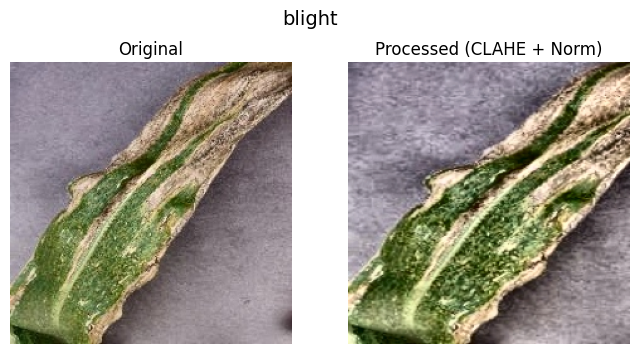

In [ ]:
class_name = 'blight'
test_image_path = f'/content/blight_dataset_processed/Blight/Corn_Blight (1002).JPG'
original_img, processed_img = smart_leaf_crop(test_image_path, class_name)
if processed_img is not None:
    show_images(original_img, processed_img, title=class_name)
else:
    print("Leaf not detected in the image.")

In [ ]:
import os
from tqdm import tqdm

# ✅ ইনপুট ও আউটপুট ফোল্ডার
input_root = '/content/extracted_thesis/data'
output_root = '/content/Maize'  # এখানে সেভ হবে

# ✅ সব ক্লাসের উপর লুপ চালাও
for class_name in os.listdir(input_root):
    class_path = os.path.join(input_root, class_name)
    if not os.path.isdir(class_path):
        continue

    # ✅ সেভ ফোল্ডার বানাও
    save_folder = os.path.join(output_root, class_name)
    os.makedirs(save_folder, exist_ok=True)

    # ✅ প্রতিটি ছবির উপর কাজ করো
    for img_name in tqdm(os.listdir(class_path), desc=f'Processing {class_name}'):
        img_path = os.path.join(class_path, img_name)
        save_path = os.path.join(save_folder, img_name)

        try:
            original_img, processed_img = smart_leaf_crop(img_path, class_name)
            if processed_img is not None:
                # [0–1] scale → [0–255] uint8 এ রূপান্তর
                img_uint8 = (processed_img * 255).astype('uint8')
                img_bgr = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2BGR)
                cv2.imwrite(save_path, img_bgr)
        except Exception as e:
            print(f"Failed on {img_path}: {e}")

Processing Blight: 100%|██████████| 1146/1146 [00:06<00:00, 174.10it/s]


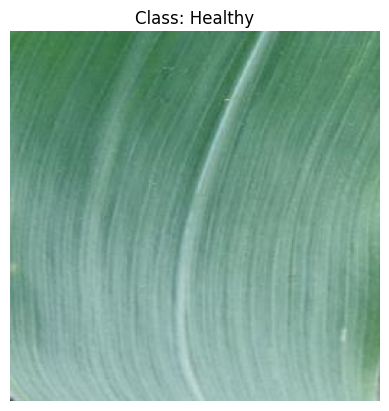

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from skimage.io import imread

# sob class folder list kora
classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

# ekti random class select
random_class = random.choice(classes)
class_path = os.path.join(dataset_path, random_class)

# sei class folder theke random image select
images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
random_image = random.choice(images)
img_path = os.path.join(class_path, random_image)

# image load & display
img_data = imread(img_path)
plt.imshow(img_data, cmap='gray')
plt.title(f"Class: {random_class}")
plt.axis('off')
plt.show()


# Data Split : 70 - 30  

In [ ]:
# Create dataframe from image paths
import pandas as pd
from glob import glob
from sklearn.model_selection import train_test_split
import os

image_paths = glob(f'{'/content/Maize'}/*/*.*')
data = pd.DataFrame({
    'filepath': image_paths,
    'label': [os.path.basename(os.path.dirname(p)) for p in image_paths]
})

# Stratified Split
train_df, temp_df = train_test_split(data, test_size=0.3, stratify=data['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

In [ ]:
#  Copy images to split folders
import shutil
from tqdm import tqdm

def copy_images(df, split_name, base_dir='/content/split'):
    for _, row in tqdm(df.iterrows(), total=len(df)):
        class_dir = os.path.join(base_dir, split_name, row['label'])
        os.makedirs(class_dir, exist_ok=True)
        shutil.copy(row['filepath'], class_dir)

copy_images(train_df, 'train')
copy_images(val_df, 'val')
copy_images(test_df, 'test')


100%|██████████| 629/629 [00:00<00:00, 3002.38it/s]


### Data augmentation

In [ ]:
import os
import cv2
import albumentations as A
from tqdm import tqdm
import random

# ✅ Base directory of your extracted split dataset
base_train_dir = '/content/split/train'

# ✅ Desired target per class
TARGET_PER_CLASS = 2000

# ✅ Augmentation pipeline
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Rotate(limit=30, p=0.5),
    A.RandomShadow(p=0.3),
    A.ZoomBlur(p=0.2),
   A.ShiftScaleRotate(p=0.3)
])


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [ ]:
# ✅ Apply augmentation only to classes with fewer than target images
for class_name in os.listdir(base_train_dir):
    class_path = os.path.join(base_train_dir, class_name)
    images = os.listdir(class_path)
    current_count = len(images)

    print(f"📁 {class_name}: {current_count} images")

    if current_count >= TARGET_PER_CLASS:
        continue  # Skip if already enough

    to_generate = TARGET_PER_CLASS - current_count
    img_paths = [os.path.join(class_path, img) for img in images]

    for i in tqdm(range(to_generate), desc=f"🔄 Augmenting {class_name}"):
        img_path = random.choice(img_paths)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        augmented = augment(image=img)['image']
        save_path = os.path.join(class_path, f'aug_{i}_{os.path.basename(img_path)}')
        cv2.imwrite(save_path, cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR))


📁 Gray_Leaf_Spot: 402 images


🔄 Augmenting Gray_Leaf_Spot: 100%|██████████| 1598/1598 [00:04<00:00, 382.49it/s]


📁 Common_Rust: 914 images


🔄 Augmenting Common_Rust: 100%|██████████| 1086/1086 [00:03<00:00, 327.07it/s]


📁 Healthy: 813 images


🔄 Augmenting Healthy: 100%|██████████| 1187/1187 [00:03<00:00, 334.30it/s]


📁 Blight: 802 images


🔄 Augmenting Blight: 100%|██████████| 1198/1198 [00:03<00:00, 389.44it/s]


In [ ]:
import os

dataset_path = '/content/split/train'

if not os.path.exists(dataset_path):
    print(f"❌ Dataset path not found: {dataset_path}")
else:
    class_counts = {}
    for class_name in os.listdir(dataset_path):
        class_dir = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_dir):
            num_images = len([
                f for f in os.listdir(class_dir)
                if os.path.isfile(os.path.join(class_dir, f))
            ])
            class_counts[class_name] = num_images

    print(f"\n✅ Number of classes: {len(class_counts)}")
    print("📊 Images per class:")
    for cls, count in class_counts.items():
        print(f"  {cls}: {count} images")


✅ Number of classes: 4
📊 Images per class:
  Gray_Leaf_Spot: 2000 images
  Common_Rust: 2000 images
  Healthy: 2000 images
  Blight: 2000 images


Without parameter tuning

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image dimensions and batch size
img_width, img_height = target_size
batch_size = 32

# Path to the augmented dataset
augmented_dataset_path = '/content/split/train' # Use the augmented data

# Create data generators for augmented data
train_datagen = ImageDataGenerator(
    rescale=1./105,
    validation_split=0.2 # 20% for validation
)

train_generator = train_datagen.flow_from_directory(
    augmented_dataset_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    augmented_dataset_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(train_generator.num_classes, activation='softmax')  # Output layer with number of classes
])

# Compile the model
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()


Found 6400 images belonging to 4 classes.
Found 1600 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
epochs = 50 # You can adjust the number of epochs
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)


Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 14s 70ms/step - accuracy: 0.9968 - loss: 0.0163 - val_accuracy: 0.8956 - val_loss: 0.6095
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.9913 - loss: 0.0310 - val_accuracy: 0.9056 - val_loss: 0.7025
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.9936 - loss: 0.0163 - val_accuracy: 0.8900 - val_loss: 0.5731
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 71ms/step - accuracy: 0.9962 - loss: 0.0161 - val_accuracy: 0.8963 - val_loss: 0.6314
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.9912 - loss: 0.0250 - val_accuracy: 0.8756 - val_loss: 0.6846
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.9876 - loss: 0.0375 - val_accuracy: 0.8612 - val_loss: 0.6979
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.9855 - loss: 0.0419 - val_accuracy: 0.8806 - val_loss: 0.9052
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 70ms/step - accuracy: 0.9935 - loss: 0.0178 - 

In [ ]:
# Evaluate the model on the validation set
loss, accuracy = model.evaluate(validation_generator)
print(f'\nValidation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')